In [1]:
%matplotlib inline
#matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context("talk")

# Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Scikit Learn
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import confusion_matrix

# others
import pandas as pd
import numpy as np
import pickle as pkl
import uuid

Using TensorFlow backend.
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

In [5]:
df = pkl.load(open('df_norm_social.pkl', 'rb'))
data = {
    'output': df['diagnostico'],
    'normalized': df.loc[:,  df.columns != 'diagnostico']
}

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.matshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           #yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, 
           #yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i , format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_yticklabels([''] + classes)

    return ax


In [7]:
"""
Classes for performing the NN training.
"""

import warnings
warnings.filterwarnings('always')

def sp(y_true, y_pred, cut=0.):
    false_output_idx = np.where(y_pred < cut)
    output= np.ones(y_pred.shape)
    output[false_output_idx] = -1
    output = output.T[0]
    cm_ = confusion_matrix(y_true, output)
    cm_ = cm_.astype('float') / cm_.sum(axis=1)[:, np.newaxis]
    if cm_.shape[0] != 1:
        no_class_prob, class_prob = cm_.diagonal()
    else:
        # For the leaveOneOut case
        no_class_prob, class_prob = cm_[0], cm_[0]
    geometric_mean = np.sqrt(no_class_prob * class_prob)
    mean = np.mean([no_class_prob, class_prob])
    SP = np.sqrt(geometric_mean * mean)
    return SP


def sp_max(y_true, y_pred):
    cuts = np.arange(-1., 1., .05)
    sps = [sp(y_true, y_pred, cut)
           for cut in cuts]
    sp_max = np.max(sps)
    sp_max_cut = np.argmax(sps)
    return  sp_max, cuts[sp_max_cut]

In [8]:
def oversample(data):
    count_class_0, count_class_1 = data['output'].value_counts()
    class_0 = data['output'].loc[data['output'] == 1]
    class_1 = data['output'].loc[data['output'] == -1]
    class_1_over = class_1.sample(count_class_0, replace=True)
    output = pd.concat([class_0, class_1_over], axis=0)
    normalized = data['normalized'].loc[output.index.tolist()]
    return normalized, output


def xval_generator_oversampling(data, k_folds=10):
    """Generator for X-Validation using K-folds approach"""

    X, y = oversample(data)

    skf = StratifiedKFold(n_splits=k_folds)
    X = X.values.astype('float32')
    y = y.values.astype('float32')
    # Oversampling
    

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield X_train, X_test, y_train, y_test

        
def get_model(n_neurons, input_shape):
    # model template
    model = Sequential()

    model.add(Dense(n_neurons,
                    activation='tanh',
                    input_shape=(input_shape,)))
    model.add(Dense(1,
                    activation='tanh',
                    input_shape=(n_neurons,)))
    return model

In [19]:
def load_model(n_neurons, input_shape,ck_filepath):
    model = get_model(n_neurons, input_shape)
    model.load_weights(ck_filepath)  
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])   
    return model

In [9]:
def run_generator(data, k_folds=10, trials=5, n_neurons=10):
    for neurons in range(1, n_neurons + 1):
        for X_train, X_test, y_train, y_test in xval_generator_oversampling(data, k_folds):
            input_shape = X_train.shape[1]
            for trial in range(trials):
                yield(X_train, X_test, y_train, y_test, neurons, input_shape, trial)

In [10]:
total_interations = sum(1 for _ in run_generator(data))
print(total_interations)

500


In [11]:
class ModelSPCheckPoint(ModelCheckpoint):
    """
    Expand model checkpoing callback for calculating best SP
    for the best network setup.
    """
    
    def __init__(self, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1, **kwargs):
        """"""
        super(ModelSPCheckPoint, self).__init__(filepath,
                                                monitor,
                                                verbose,
                                                save_best_only,
                                                save_weights_only,
                                                mode,
                                                period)
        self.best_sp = -np.inf
        self.best_sp_train = -np.inf
        self.cut = 0.
        self.x_train = kwargs.get('x_train')
        self.y_train = kwargs.get('y_train')
        
    def on_epoch_end(self, epoch, logs={}):
        """
        """
        super(ModelSPCheckPoint, self).on_epoch_end(epoch, logs)

        if self.save_best_only:
            current = logs.get(self.monitor)
            if current == self.best:
                # Compute SP for train data and retrieve best cut
                y_train_pred = self.model.predict(self.x_train)
                sp_train, cut = sp_max(self.y_train, y_train_pred)
                self.best_sp_train = sp_train
                self.cut = cut
                # Compute SP for validation data
                y_pred = self.model.predict(self.validation_data[0])
                y_true = self.validation_data[1]
                self.best_sp = sp(y_true, y_pred, cut=cut)

In [12]:
def run_mlp(X_train, X_test, y_train, y_test,
            n_neurons, input_shape, trial):
    epochs = 1000
    batch_size = 10
    mid =  str(uuid.uuid4())
    model = get_model(n_neurons, input_shape)
    model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    result_id = '%s.%02d.%04d' % (mid, n_neurons, trial)
    filepath = ".networks/%s.hdf5" % (result_id)
    pklpath = ".networks/%s.p" % (result_id)

    checkpoint = ModelSPCheckPoint(filepath,
                                   monitor='val_loss',
                                   verbose=False,
                                   save_weights_only=True,
                                   save_best_only=True,
                                   mode='min',
                                   x_train=X_train,
                                   y_train=y_train)
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        verbose=False,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[checkpoint])


    checkpoint_file = filepath
    results =  {'id': result_id,
                'cut': checkpoint.cut,
                'val_loss_history': history.history['val_loss'],
                'loss_history': history.history['loss'],
                'n_neurons': n_neurons,
                'checkpoint_file': filepath,
                'sp': checkpoint.best_sp,
                'sp_train': checkpoint.best_sp_train} 
    with open(pklpath, 'wb') as pklfile:
        pkl.dump(results, pklfile, protocol=pkl.HIGHEST_PROTOCOL)
    return (n_neurons, result_id)

In [13]:
from joblib import Parallel, delayed
from tqdm import notebook


results = []

with Parallel(n_jobs=-1) as parallel:
     results = parallel(delayed(run_mlp)(X_train, X_test, y_train, y_test, n_neurons, input_shape, trial) 
                        for X_train, X_test, y_train, y_test, n_neurons, input_shape, trial
                        in notebook.tqdm(run_generator(data), total=total_interations))




/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/tqdm/__init__.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  TqdmDeprecationWarning)


In [14]:
results = pd.DataFrame(results, columns=['n_neurons', 'id'])
results.to_csv('.networks/results_social_oversampling.csv')

In [15]:
summary = []
for group_id, group in results.groupby('n_neurons'):
    n_neurons = group.n_neurons.unique()[0]
    for idx in group.id:
        pklpath = f'.networks/{idx}.p'
        with open(pklpath, 'rb') as pklfile:
            res = pkl.load(pklfile)
            summary.append({ 'n_neurons': n_neurons,
                             'id': idx,
                             'sp': res['sp'],
                             'sp_train': res['sp_train']})
summary = pd.DataFrame.from_records(summary)

/home/fferreira/.pyenv/versions/3.7.2/envs/pleural/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:355: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds


Text(0.5, 0.98, '')

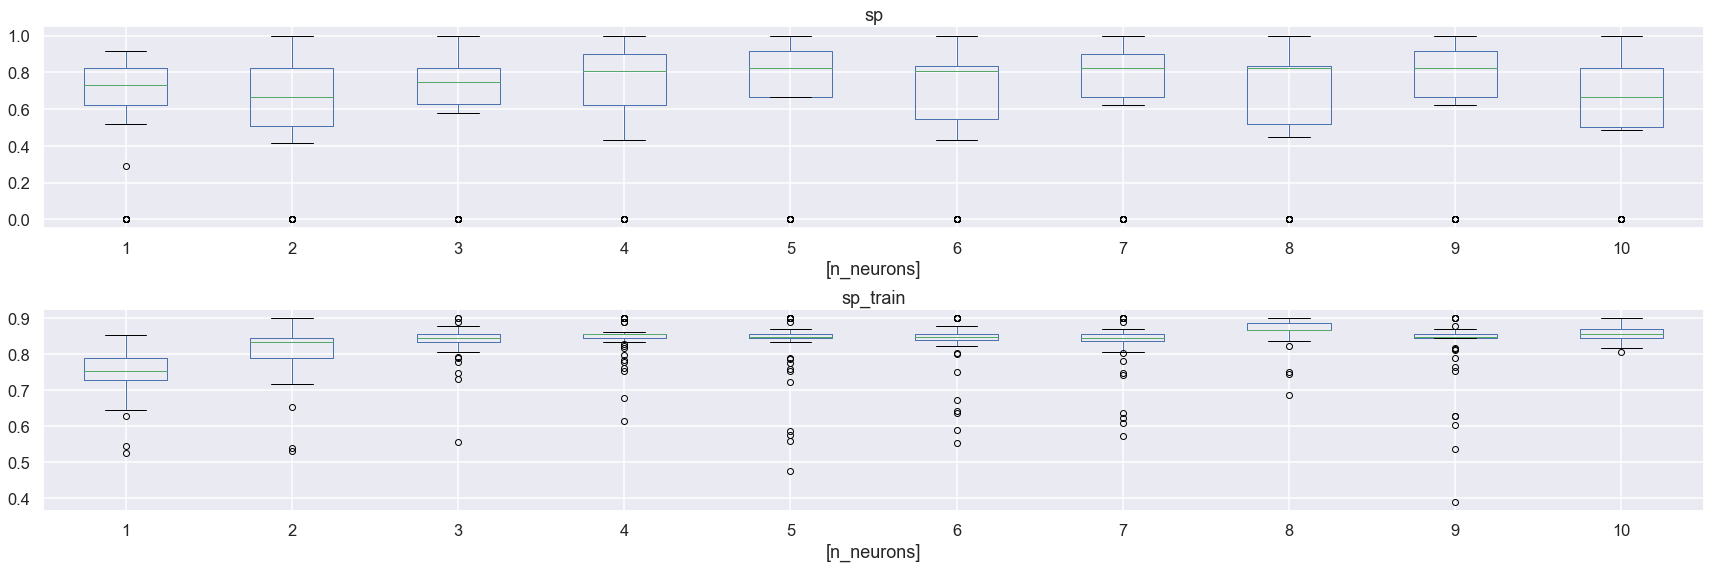

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
summary.boxplot(by='n_neurons', ax=axes)
fig.tight_layout()
fig.suptitle('')

In [36]:
summary[(summary['n_neurons']==6) & (summary['sp']> 0.8)] 

n_neurons                                            id        sp  \
250          6  03461f33-20e5-4a3a-ac12-d387db32780f.06.0000  0.914767   
251          6  c76d15c7-668a-45a6-b03d-baeec4581df2.06.0001  0.824872   
252          6  82b2aa85-f180-49a5-9aa9-3c99cb2f2f41.06.0002  0.824872   
253          6  c05aac1e-9556-4ef2-930d-dfa9d8bb0bca.06.0003  0.914767   
254          6  1399d4cd-5a57-477b-87aa-8e42adb24cc6.06.0004  0.824872   
256          6  3bb8956f-afeb-4010-8c49-5e6ea70b4e63.06.0001  0.824872   
258          6  3b3e888c-fd7b-457b-a1b6-5db21512b667.06.0003  0.824872   
259          6  4c8bcd41-26b1-4475-9974-87b21b3c1bd0.06.0004  0.824872   
260          6  20a1ff1a-b352-4ac4-a7c5-91d560d9c63d.06.0000  1.000000   
261          6  f1851acc-73b2-4fb5-95e9-8b8a924d1a05.06.0001  0.914767   
262          6  755ad237-5f37-42ba-bffd-ee2fc45dd0a4.06.0002  0.833333   
263          6  5001ffe7-5d26-45ce-91f8-b13f78e36649.06.0003  0.833333   
264          6  2bff5a69-6e70-4881-83b4-ee62cf68a1f9.06.0004  0.833333   
265          6  53aa7dc2-ac86-4c29-8d1e-4d7a2e90fb6b.06.0000  0.914767   
266          6  45f438a9-bcf6-42d1-94d0-87ca8c174152.06.0001  0.824872   
267          6  ce94dbb5-2290-4fe5-96c7-45295eca71f4.06.0002  0.824872   
268          6  e015f9b7-abb1-4061-ae4f-2eaf2cf47cd7.06.0003  0.824872   
269          6  3190711d-4924-41c8-8237-1dc9967e53d5.06.0004  0.824872   
271          6  50204855-367c-42fc-8985-4820f172c4c4.06.0001  0.914767   
273          6  2259cd8b-2ff3-4eea-ad65-3761524b51ac.06.0003  0.914767   
276          6  c535a918-52b5-4b64-b41d-2a79395954ce.06.0001  0.914767   
277          6  7692cef1-b0ff-4f3d-98b7-b0a4d8974220.06.0002  0.824872   
280          6  da45043f-26ea-44f9-977b-6fd736d1f15d.06.0000  0.897209   
281          6  e67c5753-69c3-4b97-a672-5da837f352c5.06.0001  0.897209   
284          6  4a0ed9d1-fa57-4e0d-b6b4-e5568d936511.06.0004  1.000000   

     sp_train  
250  0.843304  
251  0.843304  
252  0.832275  
253  0.843304  
254  0.843304  
256  0.854245  
258  0.854245  
259  0.854245  
260  0.832275  
261  0.843304  
262  0.843304  
263  0.843304  
264  0.832275  
265  0.854245  
266  0.854245  
267  0.854245  
268  0.854245  
269  0.854245  
271  0.843304  
273  0.843304  
276  0.854245  
277  0.798620  
280  0.846531  
281  0.846531  
284  0.640099

In [42]:
filepath = ".networks/3190711d-4924-41c8-8237-1dc9967e53d5.06.0004"
best_model  = load_model(6, 15, filepath + '.hdf5')
with open(filepath + ".p", "rb") as pfile:
    res = pkl.load(pfile)

Confusion matrix, without normalization


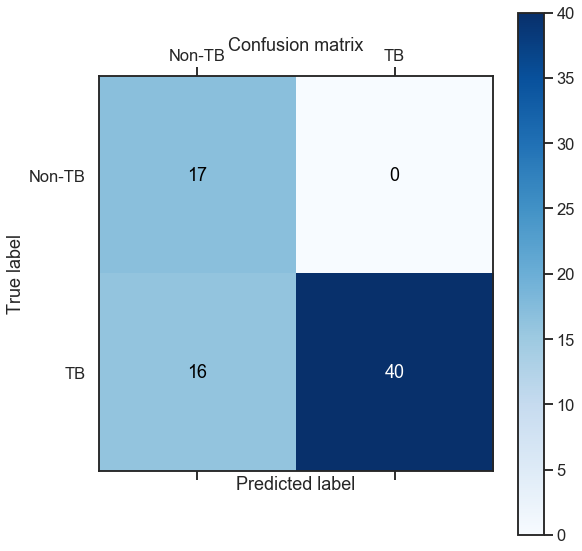

In [43]:
import itertools
import numpy as np
y_pred_out = best_model.predict(data['normalized'].values).reshape(-1)
y_pred = 2 * (y_pred_out > res['cut']) - 1
y_test = data['output'].values


with sns.axes_style('white'):
    sns.set_context("talk")
    ax = plot_confusion_matrix(y_test, y_pred, classes=['Non-TB', 'TB'],
                               title='Confusion matrix')


Text(0.5, 1.0, 'Saída para os dados')

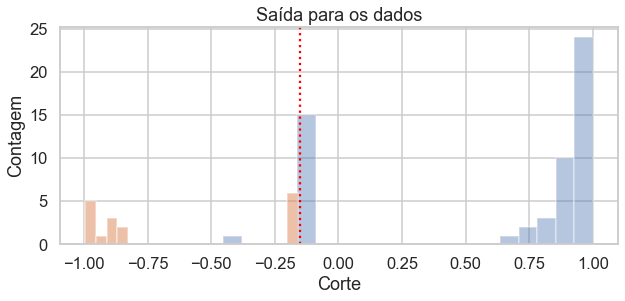

In [44]:
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(y_pred_out[np.where(y_test > res['cut'])[0]], alpha=.4, bins=20)
ax.hist(y_pred_out[np.where(y_test < res['cut'])[0]], alpha=.5, bins=20)
ax.axvline(res['cut'], linestyle=':', color='red')
ax.set_xlabel('Corte')
ax.set_ylabel('Contagem')

ax.set_title('Saída para os dados')

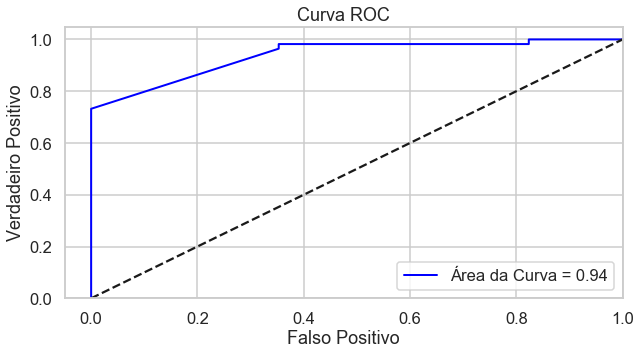

In [41]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_pred_out, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
sns.set_context('talk')
sns.set_style('whitegrid')


fig, ax = plt.subplots(1,1, figsize=(10, 5))
lw = 2

ax.plot(fpr, tpr, color='blue',
         lw=lw, label='Área da Curva = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Falso Positivo')
ax.set_ylabel('Verdadeiro Positivo')
ax.set_title('Curva ROC')
plt.legend(loc="lower right")
